In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F

import math
import matplotlib.pyplot as plt

cuda = True if torch.cuda.is_available() else False
    
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor    

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [2]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)
        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)
    
    def forward(self, x, hidden):
        
        x = x.view(-1, x.size(1))
        
        gate_x = self.x2h(x) 
        gate_h = self.h2h(hidden)
        
        gate_x = gate_x.squeeze()
        gate_h = gate_h.squeeze()
        
        i_r, i_i, i_n = gate_x.chunk(3, 1)
        h_r, h_i, h_n = gate_h.chunk(3, 1)
        
        
        resetgate = torch.sigmoid(i_r + h_r)
        inputgate = torch.sigmoid(i_i + h_i)
        newgate = torch.tanh(i_n + (resetgate * h_n))
        
        hy = newgate + inputgate * (hidden - newgate)
        
        
        return hy


In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = []
        for i in range(layer_dim):
            if i == 0:
                self.rnn.append(GRUCell(input_dim, hidden_dim))
                continue
            self.rnn.append(GRUCell(hidden_dim, hidden_dim))
        
        self.rnn = nn.ModuleList(self.rnn)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        else:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        for idx, layer in enumerate(self.rnn):
            hn = h0[idx,:,:]
            outs = []

            for seq in range(x.size(1)):
                hn = layer(x[:,seq,:], hn) 
                outs.append(hn)

            x = torch.stack(outs, 1)
        
        out = self.fc(x[:, -1, :])
        return out

In [4]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
 
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())
 
batch_size = 100
training_epochs = 2

100%|██████████| 9912422/9912422 [00:02<00:00, 4822452.82it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1160581.50it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:01<00:00, 1257849.43it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5654653.83it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)



In [6]:
input_dim = 28
hidden_dim = 128
layer_dim = 2
output_dim = 10
seq_dim = 28 
 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  


In [7]:
loss_list1 = []
for epoch in range(training_epochs):
    for idx, (images, labels) in enumerate(train_loader):
        images = images.view(-1, seq_dim, input_dim).to(device)
        labels = labels.to(device)        

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()
        
        loss_list1.append(loss.item())
         
        if idx % 100 == 0:
            correct = 0
            total = len(test_loader)
            for images, labels in test_loader:
                images = images.view(-1, seq_dim, input_dim).to(device)
                labels = labels.to(device)     
                outputs = model(images)
                predicted = torch.argmax(outputs.data, 1)
                correct += (predicted == labels).float().mean()
             
            accuracy = 100 * correct / total
             
            # Print Loss
            print(f'Iteration: {idx}. Loss: {loss.item()}. Accuracy: {accuracy}')

Iteration: 0. Loss: 2.3037145137786865. Accuracy: 8.10999870300293
Iteration: 100. Loss: 2.2919650077819824. Accuracy: 17.43999481201172
Iteration: 200. Loss: 2.243222236633301. Accuracy: 27.78000259399414
Iteration: 300. Loss: 1.9160302877426147. Accuracy: 34.769996643066406
Iteration: 400. Loss: 1.3364536762237549. Accuracy: 56.200008392333984
Iteration: 500. Loss: 0.7967077493667603. Accuracy: 67.43000793457031
Iteration: 0. Loss: 0.8015730381011963. Accuracy: 72.31000518798828
Iteration: 100. Loss: 0.7217770218849182. Accuracy: 72.9000015258789
Iteration: 200. Loss: 0.5802654027938843. Accuracy: 82.8499984741211
Iteration: 300. Loss: 0.5372673273086548. Accuracy: 83.27002716064453
Iteration: 400. Loss: 0.6887642741203308. Accuracy: 87.02001953125
Iteration: 500. Loss: 0.25060027837753296. Accuracy: 89.17002868652344


In [8]:
class Test(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(Test, self).__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x, _ = self.rnn(x)
        out = self.linear(x[:,-1,:])
        return out

In [9]:
input_dim = 28
hidden_dim = 128
layer_dim = 2
output_dim = 10
 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [10]:
loss_list2 = []
for epoch in range(training_epochs):
    for idx, (images, labels) in enumerate(train_loader):
        images = images.view(-1, seq_dim, input_dim).to(device)
        labels = labels.to(device)        

        
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()
        
        loss_list2.append(loss.item())
         
        if idx % 100 == 0:
            correct = 0
            total = len(test_loader)
            for images, labels in test_loader:
                images = images.view(-1, seq_dim, input_dim).to(device)
                labels = labels.to(device)     
                outputs = model(images)
                predicted = torch.argmax(outputs.data, 1)
                correct += (predicted == labels).float().mean()
             
            accuracy = 100 * correct / total
             
            # Print Loss
            print(f'Iteration: {idx}. Loss: {loss.item()}. Accuracy: {accuracy}')

Iteration: 0. Loss: 2.308387279510498. Accuracy: 9.819999694824219
Iteration: 100. Loss: 2.298781156539917. Accuracy: 14.289997100830078
Iteration: 200. Loss: 2.257225751876831. Accuracy: 18.999998092651367
Iteration: 300. Loss: 1.9666155576705933. Accuracy: 33.31000518798828
Iteration: 400. Loss: 1.568081021308899. Accuracy: 48.309993743896484
Iteration: 500. Loss: 0.8844009637832642. Accuracy: 65.3499984741211
Iteration: 0. Loss: 0.7827057838439941. Accuracy: 70.55001068115234
Iteration: 100. Loss: 0.6959044933319092. Accuracy: 77.80999755859375
Iteration: 200. Loss: 0.7663732171058655. Accuracy: 80.75000762939453
Iteration: 300. Loss: 0.28537607192993164. Accuracy: 82.07998657226562
Iteration: 400. Loss: 0.39852845668792725. Accuracy: 85.22001647949219
Iteration: 500. Loss: 0.39460521936416626. Accuracy: 88.1600112915039


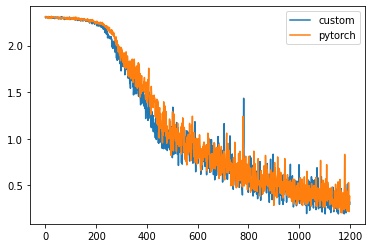

In [11]:
plt.plot(loss_list1, label='custom')
plt.plot(loss_list2, label='pytorch')

plt.legend()
plt.show()

In [36]:
from __future__ import print_function
from __future__ import division

import torch
import torch.nn as nn
import torch.nn.functional as F


class RNN(nn.Module):
    """
    Implementation of recurrent neural network using
    `nn.Linear` class following "Generating Sequences With 
    Recurrent Neural Networks" by Alex Graves.
    There are 4 types of layer connections:
    - input to all hidden layers
    - hiddens to all next layer hidden layers
    - all previous time step hiddens to all current time step hiddens
    - hiddens to all outputs
    Note that the `hidden_size` is same for all layers.
    
    TODO as follows:
      - Add sequence of inputs producing sequence of corresponding
        outputs after forward pass.
      - Make this RNN bidirectional.
    """
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, bidirectional=False):
        super(RNN, self).__init__()
        # Set the sizes of layers and more.
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        #self.sequence_length = sequence_length
        self.num_layers = num_layers

        self.ih = nn.ModuleList()    # input to hidden (all) like skip connections
        self.hh = nn.ModuleList()    # current hidden to next layer hidden
        self._hh = nn.ModuleList()   # previous in time hidden to current hidden
        if bidirectional:   # TODO
            self.hh_ = nn.ModuleList()   # future time hidden to current hidden
        self.ho = nn.ModuleList()    # all hidden layers to output connections

        # Initialize all layers.
        for _ in range(self.num_layers):
            self.ih.append(nn.Linear(self.input_size, self.hidden_size))
            self._hh.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.ho.append(nn.Linear(self.hidden_size, self.output_size))
        for _ in range(1, self.num_layers):  # connections are one less than number of layers
            self.hh.append(nn.Linear(self.hidden_size, self.hidden_size))

        # Set the lower limit for `num_layers`.
        assert num_layers >= 1, '`num_layers` must be >= 1. Default: 1'

    def init_hidden(self):
        if torch.cuda.is_available():
            return Variable(torch.zeros(self.num_layers, self.hidden_size).cuda())
        else:
            return Variable(torch.zeros(self.num_layers, self.hidden_size))

    def forward(self, x, h_states):
        """Forward pass corresponds to current time step computation (`x` input)
        taking into account previous time step computation accessed from previous
        time step `h_states`.
        `x`: [batch_size, seq_len, input_size]
        """
        # Compare length of `h_states` to `num_layers`.
        assert len(h_states) == self.num_layers, 'Number of `h_states` must be equal to `num_layers`.'
        # Stare all `h_states` in `stored_h_states`.
        stored_h_states = []

        # Compute for all the hidden layers.
        for layer in range(self.num_layers):
            if layer == 0:  # if this is the first layer
                h1 = torch.tanh(self.ih[layer](x) + self._hh[layer](h_states[layer]))
                stored_h_states.append(h1)
            else:
                hn = torch.tanh(self.ih[layer](x) + self._hh[layer](h_states[layer]) + self.hh[layer - 1](h1))
                stored_h_states.append(hn)

        # Compute the output using all the previously computed hidden layers,
        out = 0
        for layer in range(self.num_layers):
            out += self.ho[layer](stored_h_states[layer])
        return out, stored_h_states

    def __str__(self):
        return 'RNN(input_size={}, hidden_size={}, output_size={}, num_layers={})'.format(
            self.input_size, self.hidden_size, self.output_size, self.num_layers
        )

In [45]:
from __future__ import print_function
from __future__ import division

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(RNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        if self.nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity selected for RNN.")

        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)


    def forward(self, input, hx=None):

        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       hx: of shape (batch_size, hidden_size)
        # Output:
        #       hy: of shape (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))

        hy = (self.x2h(input) + self.h2h(hx))

        if self.nonlinearity == "tanh":
            hy = torch.tanh(hy)
        else:
            hy = torch.relu(hy)

        return hy

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bias=True, activation='tanh'):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        self.rnn_cell_list = nn.ModuleList()

        if activation == 'tanh':
            self.rnn_cell_list.append(RNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(RNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif activation == 'relu':
            self.rnn_cell_list.append(RNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(RNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
        else:
            raise ValueError("Invalid activation.")

        self.fc = nn.Linear(self.hidden_size, self.output_size)


    def forward(self, input, hx=None):

        # Input of shape (batch_size, seqence length, input_size)
        #
        # Output of shape (batch_size, output_size)

        if hx is None:
            if torch.cuda.is_available():
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))

        else:
             h0 = hx

        outs = []

        hidden = list()
        for layer in range(self.num_layers):
            hidden.append(h0[layer, :, :])

        for t in range(input.size(1)):

            for layer in range(self.num_layers):

                if layer == 0:
                    hidden_l = self.rnn_cell_list[layer](input[:, t, :], hidden[layer])
                else:
                    hidden_l = self.rnn_cell_list[layer](hidden[layer - 1],hidden[layer])
                hidden[layer] = hidden_l

                hidden[layer] = hidden_l

            outs.append(hidden_l)

        # Take only last time step. Modify for seq to seq
        out = outs[-1].squeeze()

        out = self.fc(out)


        return out

In [46]:
input_dim = 28
hidden_dim = 128
layer_dim = 2
output_dim = 10
 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleRNN(input_dim, hidden_dim, layer_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [47]:
loss_list3 = []
for epoch in range(training_epochs):
    for idx, (images, labels) in enumerate(train_loader):
        images = images.view(-1, seq_dim, input_dim).to(device)
        labels = labels.to(device)        

        optimizer.zero_grad()
        outputs = model(images)
        #print(hidden.type())
        loss = criterion(outputs, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()
        
        loss_list3.append(loss.item())
         
        if idx % 100 == 0:
            correct = 0
            total = len(test_loader)
            for images, labels in test_loader:
                images = images.view(-1, seq_dim, input_dim).to(device)
                labels = labels.to(device)     
                outputs = model(images)
                predicted = torch.argmax(outputs.data, 1)
                correct += (predicted == labels).float().mean()
             
            accuracy = 100 * correct / total
             
            # Print Loss
            print(f'Iteration: {idx}. Loss: {loss.item()}. Accuracy: {accuracy}')

Iteration: 0. Loss: 2.2902984619140625. Accuracy: 9.909998893737793
Iteration: 100. Loss: 1.506956934928894. Accuracy: 50.199974060058594
Iteration: 200. Loss: 1.0384581089019775. Accuracy: 67.4000015258789
Iteration: 300. Loss: 0.6193744540214539. Accuracy: 77.09000396728516
Iteration: 400. Loss: 1.1158374547958374. Accuracy: 63.900001525878906
Iteration: 500. Loss: 0.6966024041175842. Accuracy: 66.7300033569336
Iteration: 0. Loss: 0.5392341017723083. Accuracy: 83.35999298095703
Iteration: 100. Loss: 0.5247642397880554. Accuracy: 85.55996704101562
Iteration: 200. Loss: 0.9409030079841614. Accuracy: 63.610008239746094
Iteration: 300. Loss: 0.3186214566230774. Accuracy: 89.49002075195312
Iteration: 400. Loss: 0.5368098616600037. Accuracy: 88.81001281738281
Iteration: 500. Loss: 0.2836982309818268. Accuracy: 90.87000274658203


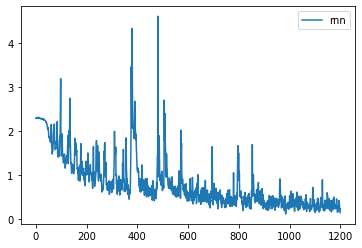

In [48]:
plt.plot(loss_list3, label='rnn')

plt.legend()
plt.show()

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.xh = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):

        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       hx: of shape (batch_size, hidden_size)
        # Outputs:
        #       hy: of shape (batch_size, hidden_size)
        #       cy: of shape (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))
            hx = (hx, hx)

        hx, cx = hx

        gates = self.xh(input) + self.hh(hx)

        # Get gates (i_t, f_t, g_t, o_t)
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        i_t = torch.sigmoid(input_gate)
        f_t = torch.sigmoid(forget_gate)
        g_t = torch.tanh(cell_gate)
        o_t = torch.sigmoid(output_gate)

        cy = cx * f_t + i_t * g_t

        hy = o_t * torch.tanh(cy)


        return (hy, cy)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bias=True):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        self.rnn_cell_list = nn.ModuleList()

        self.rnn_cell_list.append(LSTMCell(self.input_size,
                                            self.hidden_size,
                                            self.bias))
        for l in range(1, self.num_layers):
            self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                self.hidden_size,
                                                self.bias))

        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hx=None):

        # Input of shape (batch_size, seqence length , input_size)
        #
        # Output of shape (batch_size, output_size)

        if hx is None:
            if torch.cuda.is_available():
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
        else:
             h0 = hx

        outs = []

        hidden = list()
        for layer in range(self.num_layers):
            hidden.append((h0[layer, :, :], h0[layer, :, :]))

        for t in range(input.size(1)):

            for layer in range(self.num_layers):

                if layer == 0:
                    hidden_l = self.rnn_cell_list[layer](
                        input[:, t, :],
                        (hidden[layer][0],hidden[layer][1])
                        )
                else:
                    hidden_l = self.rnn_cell_list[layer](
                        hidden[layer - 1][0],
                        (hidden[layer][0], hidden[layer][1])
                        )

                hidden[layer] = hidden_l

            outs.append(hidden_l[0])

        out = outs[-1].squeeze()

        out = self.fc(out)

        return out

In [55]:
input_dim = 28
hidden_dim = 128
layer_dim = 2
output_dim = 10
 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTM(input_dim, hidden_dim, layer_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [56]:
loss_list4 = []
for epoch in range(training_epochs):
    for idx, (images, labels) in enumerate(train_loader):
        images = images.view(-1, seq_dim, input_dim).to(device)
        labels = labels.to(device)        

        optimizer.zero_grad()
        outputs = model(images)
        #print(hidden.type())
        loss = criterion(outputs, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()
        
        loss_list4.append(loss.item())
         
        if idx % 100 == 0:
            correct = 0
            total = len(test_loader)
            for images, labels in test_loader:
                images = images.view(-1, seq_dim, input_dim).to(device)
                labels = labels.to(device)     
                outputs = model(images)
                predicted = torch.argmax(outputs.data, 1)
                correct += (predicted == labels).float().mean()
             
            accuracy = 100 * correct / total
             
            # Print Loss
            print(f'Iteration: {idx}. Loss: {loss.item()}. Accuracy: {accuracy}')

Iteration: 0. Loss: 2.299607276916504. Accuracy: 9.819999694824219
Iteration: 100. Loss: 2.3081514835357666. Accuracy: 10.280001640319824
Iteration: 200. Loss: 2.3148300647735596. Accuracy: 11.350000381469727
Iteration: 300. Loss: 2.298955202102661. Accuracy: 11.350000381469727
Iteration: 400. Loss: 2.2920455932617188. Accuracy: 17.559995651245117
Iteration: 500. Loss: 2.2866051197052. Accuracy: 11.399999618530273
Iteration: 0. Loss: 2.2794723510742188. Accuracy: 11.579998970031738
Iteration: 100. Loss: 2.289656162261963. Accuracy: 12.5
Iteration: 200. Loss: 2.131073474884033. Accuracy: 23.169994354248047
Iteration: 300. Loss: 1.9935221672058105. Accuracy: 25.219993591308594
Iteration: 400. Loss: 1.8683947324752808. Accuracy: 34.42000198364258
Iteration: 500. Loss: 1.5273197889328003. Accuracy: 47.089988708496094


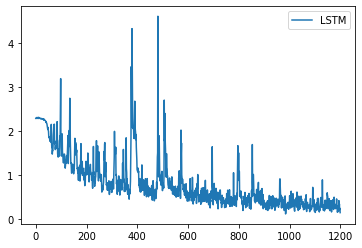

In [57]:
plt.plot(loss_list3, label='LSTM')

plt.legend()
plt.show()